# Gait Phase Feature Analysis

This notebook analyzes the EMG features distribution across the 3 gait phase classes:
- **Stance** (Class 0)
- **Swing** (Class 1)
- **None** (Class 2)

It also visualizes feature evolution over the continuous gait cycle.

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add src to path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from lib.data_loader import Enabl3sDataLoader
from lib.preprocess import EMGPreprocessor

# Plot styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

In [2]:
PHASE_NAMES = {
    0: "Stance",
    1: "Swing", 
    2: "None"
}

DYNAMIC_MODES = [1, 2, 3]
STATIC_MODES = [0, 6]

EMG_CHANNELS = ['TA', 'MG', 'RF']
TARGET_FS = 250

In [10]:
def load_data(subject, data_root="../../data"):
    print(f"Loading {subject}...")
    loader = Enabl3sDataLoader(data_root, subject, target_fs=TARGET_FS)
    raw_dir = os.path.join(data_root, subject, 'Raw')
    
    circuit_files = [f for f in os.listdir(raw_dir) if f.endswith('_raw.csv')]
    circuits_to_load = range(1, len(circuit_files) + 1)
    
    load_cols = EMG_CHANNELS + ['Mode']
    df = loader.load_dataset_batch(circuits_to_load, load_cols)
    
    if df.empty:
        return df
        
    # Filter modes
    df = df[df['Mode'].isin(DYNAMIC_MODES + STATIC_MODES)]
    
    # Preprocess
    preprocessor = EMGPreprocessor()
    df[EMG_CHANNELS] = preprocessor.apply_filter(df[EMG_CHANNELS].values)
    df[EMG_CHANNELS] = preprocessor.rectify(df[EMG_CHANNELS].values)
    
    # Add Class
    df['Phase_Class'] = 2
    is_dynamic = df['Mode'].isin(DYNAMIC_MODES)
    df.loc[is_dynamic & (df['Label_Phase'] == 1), 'Phase_Class'] = 0
    df.loc[is_dynamic & (df['Label_Phase'] == 0), 'Phase_Class'] = 1
    
    df['Phase_Name'] = df['Phase_Class'].map(PHASE_NAMES)
    
    return df

In [4]:
# Load Data
df = load_data("AB156")
print(f"Loaded {len(df)} samples")
df.head()

08:42:53 - INFO - Starting batch load: Circuits 1 to 50...


Loading AB156...


08:42:54 - INFO - Labels generated via Processed Events (Heel Contact + Toe Off). Swing Ratio: 57.07%
08:42:54 - INFO - Labels generated via Processed Events (Heel Contact + Toe Off). Swing Ratio: 33.32%
08:42:55 - INFO - Labels generated via Processed Events (Heel Contact + Toe Off). Swing Ratio: 33.05%
08:42:55 - INFO - Labels generated via Processed Events (Heel Contact + Toe Off). Swing Ratio: 40.71%
08:42:56 - INFO - Labels generated via Processed Events (Heel Contact + Toe Off). Swing Ratio: 26.70%
08:42:56 - INFO - Labels generated via Processed Events (Heel Contact + Toe Off). Swing Ratio: 30.75%
08:42:57 - INFO - Labels generated via Processed Events (Heel Contact + Toe Off). Swing Ratio: 33.10%
08:42:57 - INFO - Labels generated via Processed Events (Heel Contact + Toe Off). Swing Ratio: 30.31%
08:42:58 - INFO - Labels generated via Processed Events (Heel Contact + Toe Off). Swing Ratio: 52.06%
08:42:58 - INFO - Labels generated via Processed Events (Heel Contact + Toe Off). 

Loaded 258973 samples


,TA,MG,RF,Mode,Circuit_ID,Label_Phase,Phase_Class,Phase_Name
0,0.058931,0.041151,0.038392,0.0,1.0,0.0,2,None
1,0.028132,0.016556,0.023847,0.0,1.0,0.0,2,None
2,0.025093,0.012851,0.013541,0.0,1.0,0.0,2,None
3,0.052845,0.034950,0.025825,0.0,1.0,0.0,2,None
4,0.011730,0.004949,0.003820,0.0,1.0,0.0,2,None


## 1. Class Distribution

In [1]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='Phase_Name', order=['Stance', 'Swing', 'None'])
plt.title("Sample Count by Phase")
plt.show()

NameError: name 'plt' is not defined

## 2. Feature Distributions

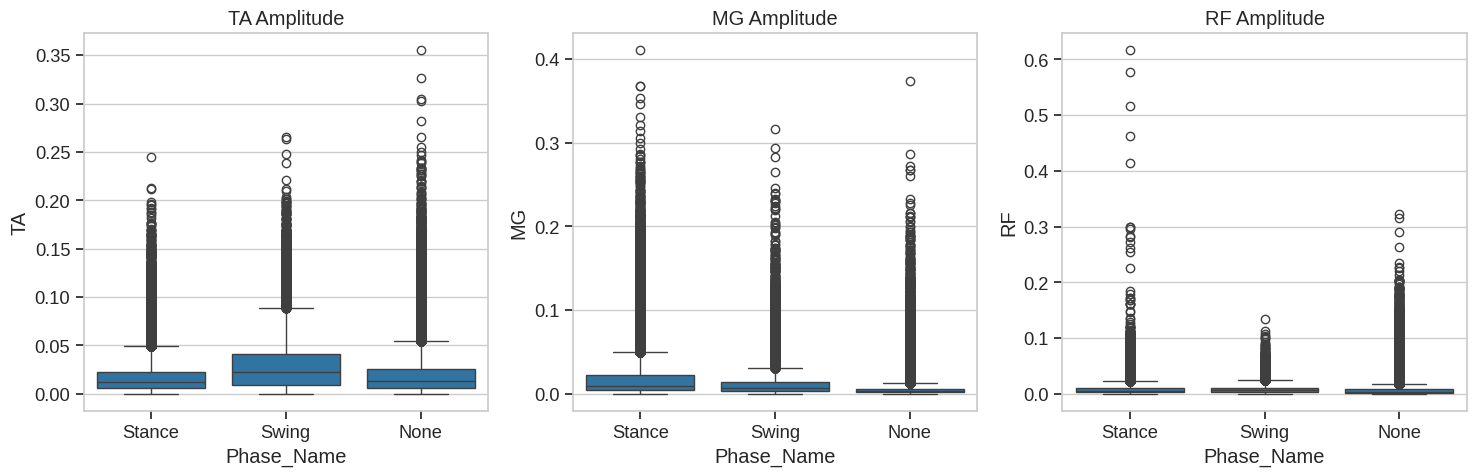

In [8]:
feat_cols = EMG_CHANNELS # Using Rectified EMG directly as proxy for amplitude features
# Or we could extract windowed features, but plotting raw rectified is also useful to see amplitude envelopes.

plt.figure(figsize=(15, 5))
for i, ch in enumerate(EMG_CHANNELS):
    plt.subplot(1, 3, i+1)
    sns.boxplot(data=df, x='Phase_Name', y=ch, order=['Stance', 'Swing', 'None'])
    plt.title(f"{ch} Amplitude")
plt.tight_layout()
plt.show()

## 3. Gait Phase Cycle Analysis
Visualizing EMG activity over the gait cycle (0% -> 100%) for Dynamic Modes.

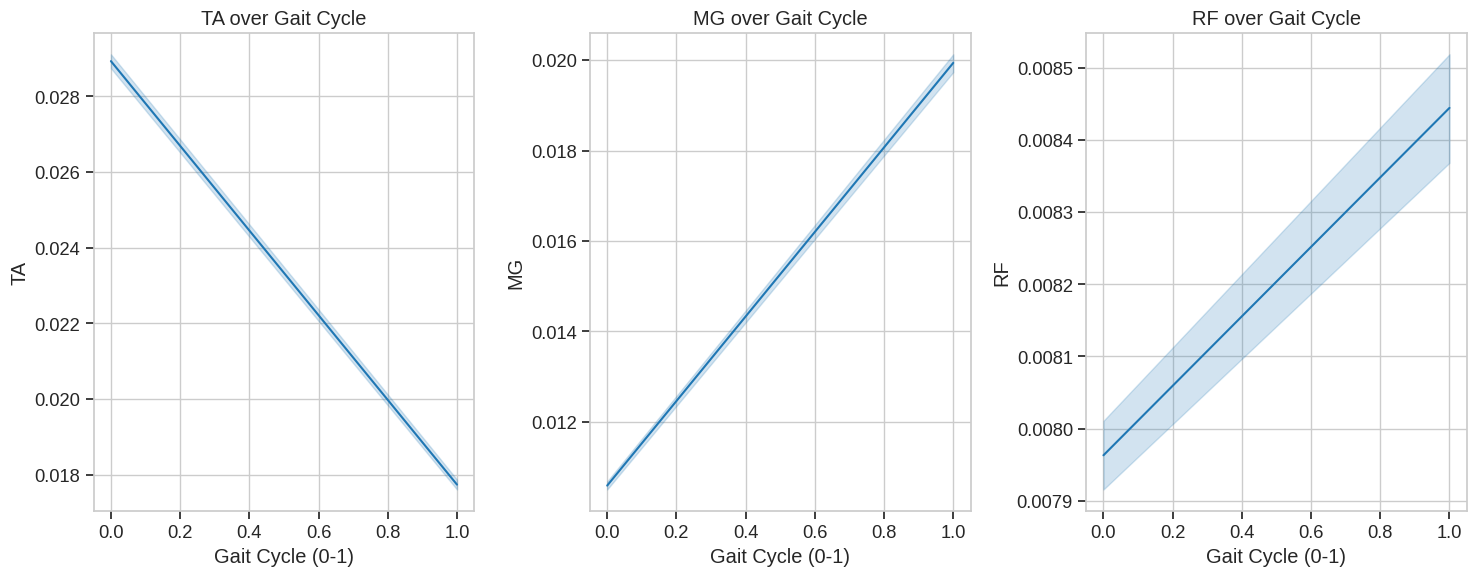

In [9]:
dynamic_df = df[df['Phase_Class'].isin([0, 1])].copy()
# Bin the cycle for smoother plots
dynamic_df['Cycle_Bin'] = pd.cut(dynamic_df['Label_Phase'], bins=50, labels=False)

plt.figure(figsize=(15, 6))
for i, ch in enumerate(EMG_CHANNELS):
    plt.subplot(1, 3, i+1)
    sns.lineplot(data=dynamic_df, x='Label_Phase', y=ch)
    plt.title(f"{ch} over Gait Cycle")
    plt.xlabel("Gait Cycle (0-1)")
plt.tight_layout()
plt.show()